In [229]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pylab
import scipy.io as sio
import scipy.linalg as slg
import math
from andylearn import mnist, KNNneighbor, PCA
#%matplotlib inline

In [269]:
data=sio.loadmat("data/orl_faces/32_32/ORL_32x32.mat")
face = data['fea']/256
face = np.squeeze(face)
label = data['gnd']

In [270]:
def MFA(data, label, k_1, k_2, d, pca_op=1):
    # Number of samples N; Dimensions D; Clases c
    data= np.matrix(data)
    [N, Dim] = data.shape
    classes = np.unique(label)
    c = len(classes)
    
    #PCA 
    if(pca_op==1):
        mapping_pca, data_pca, average = PCA.PCA(data, N - c)
    else:
        data_pca = data
    
    
    # neighbors
    data_tmp = np.sum(np.multiply(data_pca, data_pca), axis=1)
    distance=np.mat(data_tmp + data_tmp.T - 2*data_pca*data_pca.T)
    
    # the all neibors N
    neighbors = np.argsort(distance,axis=1)
    neighbors = neighbors[:, 1:]
    
    W = np.zeros((N, N)) 
    W_ = np.zeros((N, N))
    D = np.zeros((N, N)) 
    D_ = np.zeros((N, N))
    
    #  W 
    for i in range(N):
        K_1 = 0
        for j in neighbors[i].A[0]:
            if (label[j]==label[i]):
                if(K_1 < k_1):
                    W[i, j] = 1
                    W[j, i] = 1
                    K_1 += 1
    
    #  W_
    for c in classes:
        K_2 = 0
        class_c = np.array(np.where(label == c))[0]
        while K_2 < k_2:
            min_dis=np.max(distance)
            x=0
            y=0
            for i in class_c:
                for j in range(N):
                    if (label[j]!=label[i] and min_dis > distance[i, j] and W_[i, j]!=1):
                        min_dis = distance[i, j]
                        x = i
                        y = j
            W_[x, y] = 1
            W_[y, x] = 1
            K_2 += 1
    for i in range(N):
        for j in range(N):
            D[i, i] += W[i, j]
            D_[i, i] += W_[i, j]
    
    L = D-W
    L_ = D_-W_
    X_1 = np.dot(np.dot(data_pca.T, L), data_pca)
    X_2 = np.dot(np.dot(data_pca.T, L_), data_pca).I
    eigenvalues, eigenvectors = np.linalg.eig(np.dot(X_2, X_1))
    sort_eig = np.argsort(eigenvalues)
    mapping = eigenvectors[:, sort_eig[:d]]
    if(pca_op==1):
        return np.dot(mapping_pca, mapping)
    else:
        return mapping

In [278]:
def MFA_ORL_acuracy(l):
    ## 32 * 32 ORL_faces 
    s=0.0
    for i in range(10):
        matfn = 'data/orl_faces/32_32/'+str(l)+'Train/'+str(i+1)+'.mat'
        index = sio.loadmat(matfn)
        testIdx = index['testIdx'] -1  
        trainIdx = index['trainIdx'] -1
          
        trainface = np.squeeze(face[trainIdx])
        trainlabel = np.squeeze(label[trainIdx])
        
        testface = np.squeeze(face[testIdx])
        testlabel = np.squeeze(label[testIdx]) 
        
        mapping = MFA(trainface, trainlabel, 10, 20, 42)
        traindata = np.dot(trainface, mapping)
        testdata = np.dot(testface, mapping)
        tmp=KNNneighbor.accuracy(traindata, trainlabel, testdata, testlabel, 1)
        
        print(tmp)
        s+=tmp
    return s/10

s = MFA_ORL_acuracy(6)
print("s", s)

/home/huangzhenyu/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/huangzhenyu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


0.9375
0.95625
0.93125
0.975
0.94375
0.96875
0.925
0.94375
0.91875
0.95625
s 0.945625


### The shortcoming of MFA

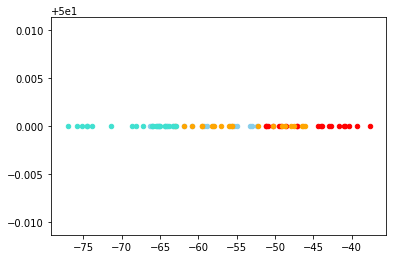

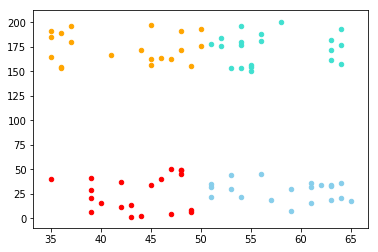

In [244]:
original_data = []
label = []
N=20
for i in range(N):
    x = random.randint(35, 50)
    y = random.randint(0, 50)
    original_data.append([x, y])
    label.append(1)
for i in range(N):
    x = random.randint(50, 65)
    y = random.randint(0, 50)
    original_data.append([x, y])
    label.append(2)
for i in range(N):
    x = random.randint(35, 50)
    y = random.randint(150, 200)
    original_data.append([x, y])
    label.append(3)
for i in range(N):
    x = random.randint(50, 65)
    y = random.randint(150, 200)
    original_data.append([x, y])
    label.append(4)


original_data=np.matrix(original_data)

mapping = MFA(original_data, label, 3, 1, 1, pca_op=0)
low_data = np.dot(original_data, mapping)
fig = plt.figure()
plotwindow = fig.add_subplot(111)

a = np.array(low_data)
# draw the scatters
color = ['red','skyblue','orange','turquoise']
for j in range(len(a)):
    plt.scatter(a[j][0],50,c=color[label[j]-1],s=20)
plt.show()

a = np.array(original_data)
# draw the scatters
color = ['red','skyblue','orange','turquoise']
for j in range(80):
    plt.scatter(a[j][0],a[j][1],c=color[label[j]-1],s=20)

plt.show()

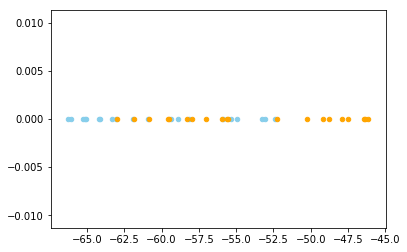

In [258]:
a = np.array(low_data)
# draw the scatters
color = ['red','skyblue','orange','turquoise']


#for j in range(20):
#    plt.scatter(a[j][0], 0, c=color[label[j]-1], s=20)
for j in range(20, 40):
    plt.scatter(a[j][0], 0, c=color[label[j]-1], s=20)
for j in range(40, 60):
    plt.scatter(a[j][0], 0,c=color[label[j]-1],s=20)
# for j in range(60, 80):
#     plt.scatter(a[j][0], 0,c=color[label[j]-1],s=20)
plt.show()